Now that we have a model that performs well and has been verified to extract meaningful features, a map to produce the features of an image which most contribute to the classification of a class can be generated.

The Saliency Map produced before performs well however it isn't able to discrimate which parts of an image correspond to "Treated" or "Untreated", rather it is better at localising where the Neurons are in the image.

A technique commonly used for object detection, the Sliding Windows algorithm, performs very well to classify regions of an image separately and for this reason it is implemented alongside the Saliency Map to determine which Neurites look "Treated" and which look "Untreated".

In [1]:
# Standard imports 
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import sys
import random

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
test_dir = '../input/neuron-cy5-images/neuron cy5 test data/Neuron Cy5 Test Data'
image_size = 2048
input_size = 331

# Keras data generator to load image samples in batches
data_gen = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True)
test_gen = data_gen.flow_from_directory(test_dir,
                                        target_size=(image_size, image_size),
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        batch_size=1,
                                        shuffle=True)

classes = dict((v, k) for k, v in test_gen.class_indices.items())
num_classes = len(classes)
num_samples = len(test_gen)

Found 100 images belonging to 2 classes.


The sliding windows algorithm will be implemented convolutionally as mentioned in the [OverFeat Paper](https://arxiv.org/abs/1312.6229). To do this, the GlobalMaxPooling2D layer after the convolutions of th VGG19 is replaced with a MaxPooling2D layer with filter size 10x10. This means that when an image of size 331x331 is passed into the model, a simple class prediction (note: this does need to be reshaped from a 4D tensor into 2D) is output but when an image of size 2048x2048 is passed, a classification map of size 55x55 is produced.

In [3]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications import VGG19
from tensorflow.python.keras.layers import MaxPooling2D, Dense, Reshape

# Create a VGG19 architecture
pretrained_model = VGG19(include_top=False,
                         pooling='none',
                         input_shape=(input_size, input_size, 3),
                         weights=None)
x = MaxPooling2D(pool_size=(10, 10), strides=(1, 1), padding='valid')(pretrained_model.output)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x) 
output = Reshape([2])(x)
vgg19_model = Model(pretrained_model.input, output)

# Create new model with modified config which accepts the input shape: [input_size, input_size, 1]
cfg = vgg19_model.get_config()
cfg['layers'][0]['config']['batch_input_shape'] = (None, None, None, 1)
model = Model.from_config(cfg)

# Load in the weights from training
weights_dir = '../input/fitting-deeper-networks-vgg19/VGG19_weights.h5'
model.load_weights(weights_dir)

With the full sized image passed through the model,  the final Dense layer outputs a 55x55 map of predictions, each corresponding to a 331x331 area of the image. Due to the Pooling layers within the model, these effectively have a step of 31 pixels 

In [4]:
from tensorflow.python.keras.layers import AveragePooling2D
from tensorflow.python.keras.layers import Lambda

pred_map = model.layers[-2].output
swmodel = Model(model.input, pred_map)

In [5]:
def unaug_img(img):
    '''
    Returns image array with pixel intensities confined to [0,1]
    '''
    img -= img.min()
    img /= img.max()
    return img

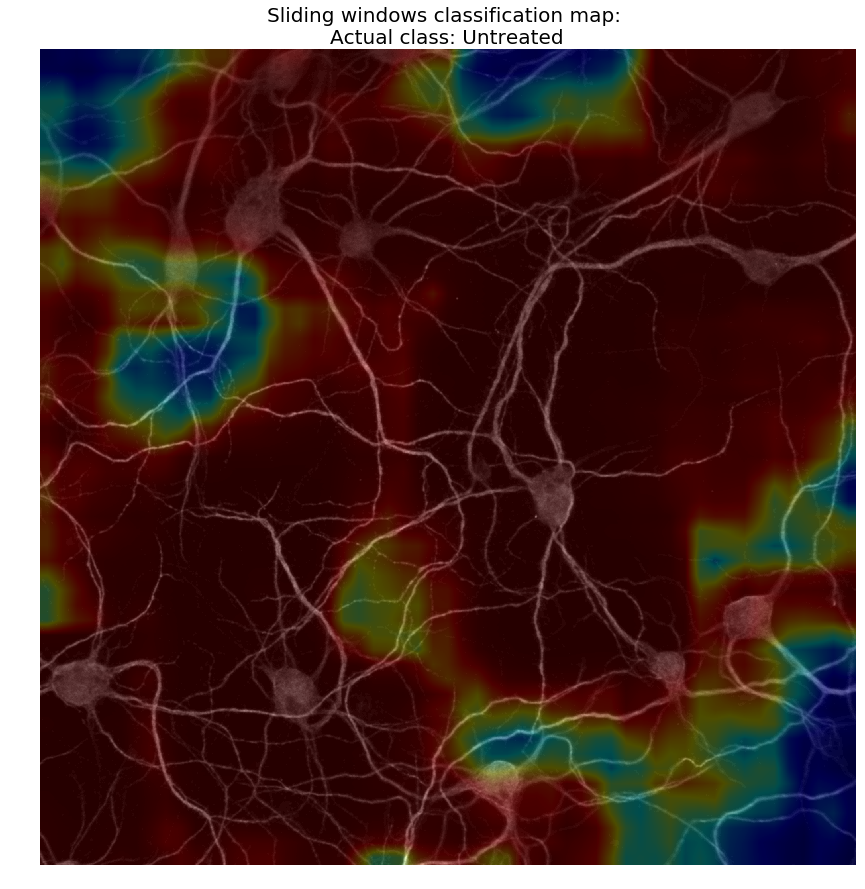

In [6]:
# Load an image using the generator
X, y = next(test_gen)
# Generate sliding windows prediction
sw_map = swmodel.predict(X)
sw_map = np.uint8(255*sw_map[0,...,1])
sw_map = cv2.resize(sw_map, (image_size, image_size))
# Apply colourmap to sliding windows map
sw_map = cv2.applyColorMap(sw_map, cv2.COLORMAP_JET) # Red indicates "Treated"
# Fix image values in [0, 255] and combine with sliding windows map
X = np.uint8(255*unaug_img(X))
X = cv2.cvtColor(X[0], cv2.COLOR_GRAY2RGB)
class_map = cv2.addWeighted(X, 0.7, sw_map, 0.3, 0)

# Display image
plt.figure(figsize=(15, 15))
plt.title('Sliding windows classification map: \nActual class: '+classes[y[0,1]], fontsize=20)
plt.imshow(class_map)
plt.axis('off');

For the purpose of generating the Saliency Map, Guided BackPropagation is implemented.

In [7]:
# Registering GuidedRelu as a tensorflow gradient
try:
    @tf.RegisterGradient('GuidedRelu')
    def _guided_backprop(op, grad):
        dtype = op.outputs[0].dtype
        gate_g = tf.cast(grad > 0., dtype)
        gate_y = tf.cast(op.outputs[0] > 0, dtype)
        return gate_y * gate_g * grad
except KeyError: #KeyError is raised if 'GuidedRelu' has already been registered as a gradient
    pass

In [8]:
from tensorflow.python.keras.activations import linear

cfg = model.get_config()
g = tf.get_default_graph()
# Compiling the model within this loop implements Guided Backprop
with g.gradient_override_map({'Relu': 'GuidedRelu'}):
    # Copying model using it's config
    guid_model = Model.from_config(cfg)
    # Replacing the activation on the last layer with linear
    guid_model.layers[-2].activation = linear # Index=-2 due to Reshape layer
    guid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])

In [9]:
from tensorflow.python.keras import backend as K
def generate_saliency(img, class_pred, model=guid_model):
    '''
    Generates the Saliency map of img with respect to class_pred, given the Keras model.
    '''
    inp = model.input
    class_outp = model.output[:, class_pred]
    sal = K.gradients(tf.reduce_sum(class_outp), inp)[0]
    # Keras function returning the saliency map given an image input
    sal_fn = K.function([inp], [sal])
    # Generating the saliency map and normalizing it
    img_sal = sal_fn([np.resize(img, (1, input_size, input_size, 1))])[0]
    img_sal = np.maximum(img_sal, 0)
    img_sal /= img_sal.max()
    return img_sal

Now the function to create the mapping is created. The Saliency Map is colored by the regional classification to give an visualisation of which neurons indicate "Treated" and which indicate "Untreated". 

However, the regional classification is sometimes unsure and outputs values close to 0.5. To remove these the optimal thresholds produced by maximising Youden's J Statistic are used. If a prediction is above the threshold for a class is it coloured Red for "Treated" and Blue for "Untreated". If the prediction is not above either of these then the region is coloured Green for Uncertain.

In [10]:
def lcm(a,b):
    '''
    Returns the lowest common multiple of inputs a & b.
    '''
    from math import gcd
    return (a*b)//gcd(a,b)

In [11]:
# Loading optimal thresholds
file_dir = '../input/youden-s-j-statistic-for-threshold-determination/optimum_thresholds.csv'
opt_thresholds = pd.read_csv(file_dir, sep=',', header=None).iloc[1:,1:].values

def generate_mapping(inp_img, opt_thresholds=opt_thresholds, swmodel=swmodel):
    '''
    Given an image, returns an explanation in the form of a Saliency map coloured by the sliding windows map.
    '''
    img = np.copy(inp_img)
    map_size = img.shape[1]
    # Load prediction map  
    pred_map = swmodel.predict(img)[0,...,1]
    # Round predictions to 0 and 1 if confident and 0.5 if not
    rounded_map = np.heaviside(pred_map-1+opt_thresholds[0], 1)/2 + np.heaviside(pred_map-opt_thresholds[1], 1)/2
    # Produce coloured heatmap where red=treated, green=unsure and blue=untreated
    heatmap = np.zeros(np.append(rounded_map.shape,[3]))
    heatmap[np.where(rounded_map==1)] = [0, 0, 1]
    heatmap[np.where(rounded_map==1/2)] = [0, 1, 0]
    heatmap[np.where(rounded_map==0)] = [1, 0, 0]
    heatmap = cv2.resize(heatmap, (map_size,map_size))
    #Reshape image to 3D tensor
    img = np.reshape(img, [image_size, image_size, 1])
    img_small = cv2.resize(img, (input_size, input_size))
    # Generate saliency
    saliencys = [generate_saliency(img_small, i) for i in range(num_classes)]
    # Resize image and convert to RGB
    img = np.uint8(255*unaug_img(img))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
    sal = cv2.resize(saliencys[0][0,...,0], (map_size, map_size))
    # Histogram equalize for visualisation
    sal = cv2.equalizeHist(np.uint8(255*sal))
    sal = cv2.cvtColor(sal, cv2.COLOR_GRAY2RGB)/255
    #Combine saliency and heatmap
    mapping = np.multiply(heatmap, sal)
    #Normalize
    for i in range(mapping.shape[2]):
        if mapping[...,i].max() != 0:
            mapping[...,i] /= mapping[...,i].max()
    mapping = np.uint8(255*mapping)
    return cv2.addWeighted(img, 0.7, mapping, 0.3, 0)

In [12]:
def generate_prediction(inp_img, model=model):
    '''
    Generate prediction  on full-sized image by resizing
    '''
    img = np.copy(inp_img)
    img = np.squeeze(img, axis=(0,-1))
    img = cv2.resize(img, (input_size, input_size))
    img = np.reshape(img, [1, input_size, input_size, 1])
    pred = model.predict(img, steps=1)
    return pred[0]

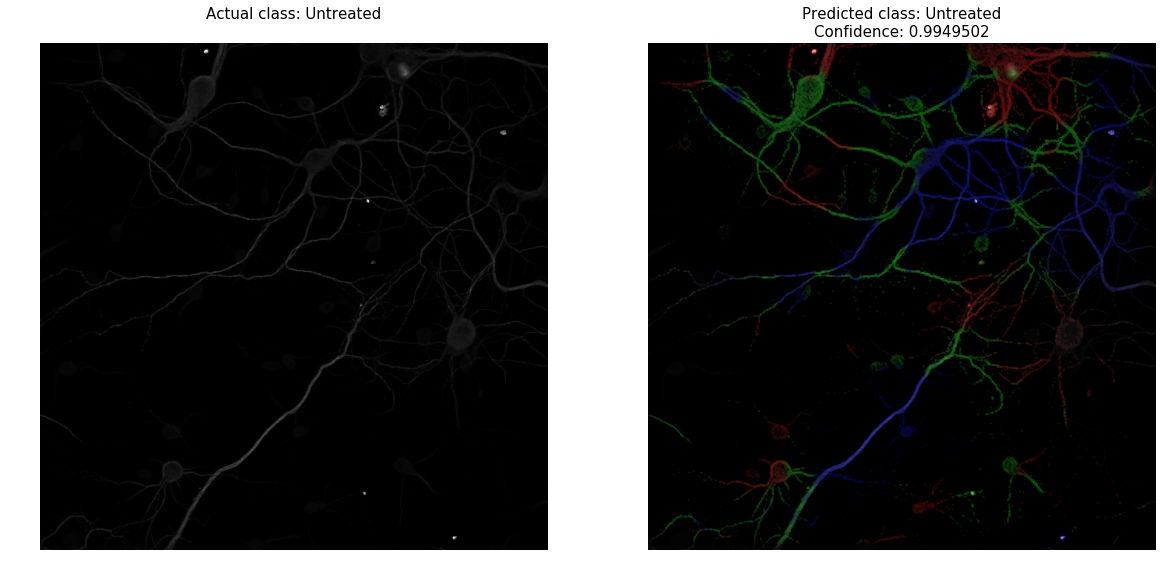

In [13]:
# Load random sample
X, y = next(test_gen)
# Generate prediction
y_pred = generate_prediction(X)
# Generate explanation
final_map = generate_mapping(X)
class_pred = classes[y_pred[1].round()]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# Show image
ax[0].set_title('Actual class: '+classes[y[0, 1]]+'\n', fontsize=15)
ax[0].imshow(unaug_img(X[0,...,0]), cmap='gray')
ax[0].axis('off')
# Show mapping
ax[1].set_title('Predicted class: '+str(class_pred)+'\nConfidence: '+str(y_pred.max()), fontsize=15);
ax[1].imshow(final_map);
ax[1].axis('off');